# Capstone Project for Springboard Data Science Intensive Program

## Santander Product Recommendation 

Santander is a bank which offers financial products and services. The whole dataset is 1.5 years and has monthly records of multiple columns that store customer’s information, such as customer code, status of employment, customer’s country residence, age, gender of customer, gross income of the household, etc. There are also 24 product columns storing product items a customer has, such as "credit card", "savings account", “mortgage”, “short-term deposits”, “medium-term deposits”, “long-term deposits”, etc.

Link of data source: https://www.kaggle.com/c/santander-product-recommendation

Goal: To predict what products Santander’ customers will purchase in the next month based on past data.


## Description of data fields.
| Column |   Description |
|------|------|
|employee_index|A active, B ex employed, F filial, N not employee, P pasive|
|country_residence|Customer's Country residence|
|sex|Customer's sex|
|age|Age|
|first_join_date|The date in which the customer became as the first holder of a contract in the bank|
|new_customer_index|New customer Index. 1 if the customer registered in the last 6 months|
|seniority|Customer seniority (in months)|
|primary|1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)|
|customer_type|Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner)|
|customer_relation|Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential)|
|residence_idx|Residence index (S (Yes) or N (No) if the residence country is the same than the bank country)|
|foreigner_idx|Foreigner index (S (Yes) or N (No) if the customer's birth country is different than the bank country)
|channel|Channel used by the customer to join|
|deceased|Deceased index. N/S|
|address|Address type. 1, primary address|
|province_code|Province code (customer's address)|
|province_name|Province name|
|activity_idx|Activity index (1, active customer; 0, inactive customer)|
|gross_income|Gross income of the household|
|segment|segmentation: 01 - VIP, 02 - Individuals 03 - college graduated|


In [1]:
import csv
import datetime
from operator import sub
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing, ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
import sys


Lists of feature columns we will read in and the target column we will model. The "current_account" has the most coverage based on the results in our exploratory data analyses. So we focus on this product for my modeling project.  

In [2]:
feature_cols = ["employee_index","country_residence","sex","age","first_join_date","new_customer_index","seniority","primary","customer_type","customer_relation","residence_idx","foreigner_idx","channel","deceased","address","province_code","province_name","activity_idx","gross_income","segment"]
#target_cols=["saving_account","guarantees","current_account","derivada_account","payroll_account","junior_account","mas_particular_account","particular_account","particular_plus_account","short-term_deposits","medium-term_deposits","long-term_deposits","e-account","funds","mortgage","pensions","loans","taxes","credit_card","securities","home_account","payroll","pensions_1","direct_debit"]
#target_cols = target_cols[2:]
target_cols = ["current_account"]
all_cols = feature_cols+target_cols


In [4]:
print("Number of columns read from the training data:", len(all_cols))

('Number of columns read from the training data:', 21)


Function to read the target (product) column and return its value.

In [5]:
def getTarget(row):
    tlist = []
    for col in target_cols:
            if row[col].strip() in ['', 'NA']:
                    target = 0
            else:
                    target = int(float(row[col]))
            tlist.append(target)
    return tlist


Function to read all columns (feature and target) from the csv file. Only date in '2016-05-28' is used to build the model. Return the data as a list. 

In [6]:
def processData(in_file_name):
    x_vars_list = []
    #y_vars_list = []
    for row in csv.DictReader(in_file_name, fieldnames = ( "date","id","employee_index","country_residence","sex",
                                                          "age","first_join_date","new_customer_index","seniority",
                                                          "primary","last_date_primary","customer_type","customer_relation",
                                                          "residence_idx","foreigner_idx","spouse_idx","channel","deceased",
                                                          "address","province_code","province_name","activity_idx",
                                                          "gross_income","segment","saving_account","guarantees",
                                                          "current_account","derivada_account","payroll_account",
                                                          "junior_account","mas_particular_account","particular_account",
                                                          "particular_plus_account","short-term_deposits","medium-term_deposits",
                                                          "long-term_deposits","e-account","funds","mortgage","pensions","loans",
                                                          "taxes","credit_card","securities","home_account","payroll",
                                                          "pensions_1","direct_debit" )):
        x_vars = []
        for col in feature_cols:
            val = row[col].strip()
            x_vars.append(val)
            
        if row['date'] in [ '2016-05-28']:
            target_list = getTarget(row)
            x_vars_list.append(x_vars + target_list)
            
#assign a number for the test data
        elif row['date'] in ['2016-06-28']: 
             target_list = [0]
             x_vars_list.append(x_vars + target_list)
        else:
            continue

    return x_vars_list

Main program starts here. First read in the training data "train_ver2.csv" and save it in the dataframe.

In [7]:
if __name__ == "__main__":
    start_time = datetime.datetime.now()
    data_path = "../input/"
    train_file =  open(data_path + "train_ver2.csv")
    #train_file =  open(data_path + "train_20percent.csv")
    x_vars_list = processData(train_file)
    

    df_org = pd.DataFrame.from_records(x_vars_list, columns=all_cols)
    df = df_org
    print("Number of columns in the dataframe:")
    print(len(x_vars_list[1]))  
    print("Number of records in the dataframe:")
    print(len(df))
    

Number of columns in the dataframe:
21
Number of records in the dataframe:
931453


In [8]:
#If starting over from the training dataframe is needed. 
df = df_org

I would like to check values for each feature in this dataset. So uniq values for each feature are printed. The number of uniq values for gross_income is very large and gross income should be numerical column. It is not so useful to print that many numbers. So checking values for gross income is skipped. I will print max and min instead after converting this field to float. 

In [9]:
def print_uniq(df,feature_cols):

    for ind, feature_col in enumerate(feature_cols):

        uniq_values = list(df[feature_col].unique())

        print("uniq values for "+feature_col+": ",uniq_values)
        print("number of uniq values for "+feature_col+": ",len(uniq_values))

In [207]:
feature_cols = ["employee_index","country_residence","sex","age","first_join_date","new_customer_index","seniority",
    "primary","customer_type","customer_relation","residence_idx","foreigner_idx","channel","deceased","address",
    "province_code","province_name","activity_idx","gross_income","segment"]
feature_cols.remove("gross_income")
print("Print uniq values for each column in the dataframe:")
print_uniq(df,feature_cols)


Print uniq values for each column in the dataframe:
('uniq values for employee_index: ', ['N', 'A', 'S', 'F', 'B'])
('number of uniq values for employee_index: ', 5)
('uniq values for country_residence: ', ['ES', 'BO', 'AR', 'IN', 'RO', 'PY', 'US', 'BE', 'MD', 'CH', 'AE', 'DE', 'PL', 'CO', 'VE', 'PT', 'HN', 'FR', 'CU', 'GR', 'ET', 'CR', 'BR', 'GB', 'EC', 'IE', 'RU', 'NG', 'MA', 'CL', 'UY', 'DO', 'NZ', 'AU', 'GQ', 'SE', 'KR', 'UA', 'NL', 'IT', 'JP', 'PE', 'GT', 'LT', 'NO', 'BG', 'DZ', 'IL', 'DK', 'CA', 'PK', 'CZ', 'MX', 'AT', 'LV', 'CG', 'SA', 'LU', 'OM', 'EG', 'ZA', 'CN', 'SN', 'FI', 'GN', 'PA', 'GW', 'SV', 'SL', 'QA', 'CM', 'KZ', 'BZ', 'PR', 'AO', 'TH', 'CD', 'GM', 'SK', 'MR', 'SG', 'BA', 'CF', 'ZW', 'TR', 'HK', 'TW', 'NI', 'AL', 'MZ', 'ML', 'MK', 'HU', 'RS', 'AD', 'BM', 'PH', 'KW', 'VN', 'MM', 'GI', 'GE', 'GA', 'BY', 'CI', 'KE', 'KH', 'GH', 'LY', 'MT', 'IS', 'HR', 'EE', 'TG', 'LB', 'TN', 'JM', 'DJ'])
('number of uniq values for country_residence: ', 118)
('uniq values for sex: ', ['H

So there is only 1 value for the address. We can drop this column in our list of features. Also note for the customer_type, seems there are some mixed formats for the same type. '1' and '1.0' should be the same. Similarly '3', '3.0' and '4', 4.0' should refer to the same type. So I use replace method to make them the same.

In [10]:
df['customer_type']=df['customer_type'].replace('1.0','1')
df['customer_type']=df['customer_type'].replace('2.0','2')
df['customer_type']=df['customer_type'].replace('3.0','3')
df['customer_type']=df['customer_type'].replace('4.0','4')

Check again the uniq values for customer_type.

In [11]:
feature_cols = ["customer_type"]
print("Print uniq values for customer_type")
print_uniq(df,feature_cols)


Print uniq values for customer_type
('uniq values for customer_type: ', ['1', 'P', '3', '2', '', '4'])
('number of uniq values for customer_type: ', 6)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931453 entries, 0 to 931452
Data columns (total 21 columns):
employee_index        931453 non-null object
country_residence     931453 non-null object
sex                   931453 non-null object
age                   931453 non-null object
first_join_date       931453 non-null object
new_customer_index    931453 non-null object
seniority             931453 non-null object
primary               931453 non-null object
customer_type         931453 non-null object
customer_relation     931453 non-null object
residence_idx         931453 non-null object
foreigner_idx         931453 non-null object
channel               931453 non-null object
deceased              931453 non-null object
address               931453 non-null object
province_code         931453 non-null object
province_name         931453 non-null object
activity_idx          931453 non-null object
gross_income          931453 non-null object
segment               931453 non-n

Force 'age', 'seniority' and 'gross_income' only have numerical values or missing values (NaN) will be filled. Filter out rows that have NaN.

In [13]:
#Age and seniority may have non-numeric values. Use errors='coerce' to force them to be NaN so they can be removed.

df['age']   = pd.to_numeric(df['age'], errors='coerce')
df['seniority']   = pd.to_numeric(df['seniority'], errors='coerce')
df['gross_income']   = pd.to_numeric(df['gross_income'], errors='coerce')

##df = df[df['seniority']>0]
##df.dropna(axis=0)
#df.dropna()

#select the rows that do not have NaN
condition=~pd.isnull(df).any(axis=1)
df=df[condition]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702435 entries, 0 to 931451
Data columns (total 21 columns):
employee_index        702435 non-null object
country_residence     702435 non-null object
sex                   702435 non-null object
age                   702435 non-null int64
first_join_date       702435 non-null object
new_customer_index    702435 non-null object
seniority             702435 non-null int64
primary               702435 non-null object
customer_type         702435 non-null object
customer_relation     702435 non-null object
residence_idx         702435 non-null object
foreigner_idx         702435 non-null object
channel               702435 non-null object
deceased              702435 non-null object
address               702435 non-null object
province_code         702435 non-null object
province_name         702435 non-null object
activity_idx          702435 non-null object
gross_income          702435 non-null float64
segment               702435 non-nu

In [14]:
print("Maximum of the gross income:",max(df['gross_income']))
print("Minimum of the gross income:", min(df['gross_income']))

('Maximum of the gross income:', 28894395.510000002)
('Minimum of the gross income:', 1202.73)


## Applying Label Encoder to Categoricals

In [15]:
def prep_numeric_data(df):
    
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    feature_cols = df.columns 
    for ind, feature_col in enumerate(feature_cols):
        if df[feature_col].dtype == 'object':
            le.fit(df[feature_col])
            df[feature_col]=le.transform(df[feature_col])
    
    return df

Use function prep_numeric_data to convert categoric features to numeric features. 

In [16]:
df = prep_numeric_data(df)


/usr/people/weichun/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
    print("Number of columns in the dataframe:")
    print(len(x_vars_list[1]))  
    print("Number of records in the dataframe:")
    print(len(df))

Number of columns in the dataframe:
21
Number of records in the dataframe:
702435


I would like to check uniq values of some feature columns after using label encoder to tranform catogorical features to numeric features. Note 'gross income' is not printed since it is a numerical feature and there are too many numbers for this column. 

In [18]:
print("Print uniq values for feature column after label encoding:")
feature_cols = ["employee_index","country_residence","sex","age","first_join_date","new_customer_index","seniority",
    "primary","customer_type","customer_relation","residence_idx","foreigner_idx","channel","deceased","address",
    "province_code","province_name","activity_idx","gross_income","segment"]
feature_cols.remove("gross_income")
feature_cols.remove("first_join_date")
print_uniq(df,feature_cols)


Print uniq values for feature column after label encoding:
('uniq values for employee_index: ', [3, 0, 4, 2, 1])
('number of uniq values for employee_index: ', 5)
('uniq values for country_residence: ', [9, 11, 13, 4, 21, 23, 5, 7, 16, 1, 10, 2, 19, 12, 3, 17, 0, 14, 20, 15, 18, 6, 8, 22])
('number of uniq values for country_residence: ', 24)
('uniq values for sex: ', [1, 2, 0])
('number of uniq values for sex: ', 3)
('uniq values for age: ', [68, 42, 44, 49, 36, 41, 45, 31, 34, 37, 40, 57, 51, 66, 38, 95, 43, 29, 47, 39, 35, 74, 32, 52, 79, 94, 53, 30, 54, 50, 56, 92, 33, 48, 77, 86, 76, 26, 55, 61, 62, 70, 67, 22, 46, 60, 71, 85, 65, 88, 63, 90, 59, 78, 64, 87, 12, 58, 18, 16, 17, 83, 89, 91, 73, 69, 11, 75, 81, 82, 80, 84, 13, 15, 72, 96, 100, 93, 19, 110, 97, 20, 101, 99, 14, 98, 27, 23, 24, 105, 28, 25, 102, 21, 104, 108, 111, 103, 109, 106, 10, 114, 107, 2, 113, 112, 7, 8, 9, 6, 127, 117, 116, 115, 5, 3, 4])
('number of uniq values for age: ', 117)
('uniq values for new_customer_

In [31]:
len(df['current_account']==1)/len(df['current_account'])

1

In [19]:

X = df.drop(['address','current_account'],axis=1)
y = df['current_account']
seed = 7
test_size = 0.33
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


In [21]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [24]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import cross_val_score
else:
    from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          random_state=0)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.73 (+/- 0.00) [Logistic Regression]
ROC AUC: 0.63 (+/- 0.00) [Decision Tree]
ROC AUC: 0.65 (+/- 0.00) [KNN]


In [25]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.73 (+/- 0.00) [Logistic Regression]
ROC AUC: 0.63 (+/- 0.00) [Decision Tree]
ROC AUC: 0.65 (+/- 0.00) [KNN]
ROC AUC: 0.74 (+/- 0.00) [Majority Voting]


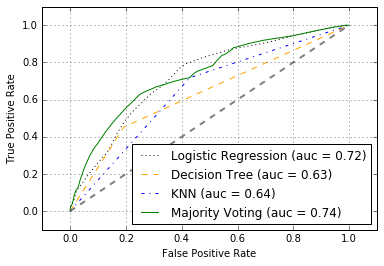

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

In [20]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231804 entries, 433312 to 369287
Data columns (total 19 columns):
employee_index        231804 non-null int64
country_residence     231804 non-null int64
sex                   231804 non-null int64
age                   231804 non-null int64
first_join_date       231804 non-null int64
new_customer_index    231804 non-null int64
seniority             231804 non-null int64
primary               231804 non-null int64
customer_type         231804 non-null int64
customer_relation     231804 non-null int64
residence_idx         231804 non-null int64
foreigner_idx         231804 non-null int64
channel               231804 non-null int64
deceased              231804 non-null int64
province_code         231804 non-null int64
province_name         231804 non-null int64
activity_idx          231804 non-null int64
gross_income          231804 non-null float64
segment               231804 non-null int64
dtypes: float64(1), int64(18)
memory usage: 35

## Model Setup

Define a function for modeling and plot feature importance.

This function will do the following:
    1. Fit the model
    2. Calculate training accuracy
    3. Calculate training AUC
    4. Calculate testing AUC
    5. Plot feature importance

In [74]:
def fit_pred(X_train, y_train, X_test, y_test, param):
#     param = {}
#     param['objective'] = 'multi:softprob'
#     param['eta'] = 0.05
#     param['max_depth'] = 8
#     param['silent'] = 1
#     #param['num_class'] = 2
#     param['eval_metric'] = "mlogloss"
#     param['min_child_weight'] = 1
#     param['subsample'] = 0.7
#     param['colsample_bytree'] = 0.7
#     param['seed'] = seed_val
#     param['objective']='binary:logistic'
    # Build the model
    num_rounds = 50  
    plst = list(param.items())
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    model = xgb.train(plst, xgtrain, num_rounds)
    
    # Model prediction on the training data
    pred_train = model.predict(xgtrain)
    predictions_train = [round(value) for value in pred_train]
    print "\nModel Report"
    print "Accuracy (Train) : %.4g" % accuracy_score(y_train, predictions_train)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y_train, pred_train)
    print "\n"
    
    # Model prediction of test data
    xgtest = xgb.DMatrix(X_test)
    pred_test = model.predict(xgtest)

    predictions_test = [round(value) for value in pred_test]
    print("Analyzing Performance on Test Data")
    print "Accuracy (Test) : %.4g" % accuracy_score(y_test, predictions_test)
    print "AUC Score (Test): %f" % metrics.roc_auc_score(y_test, pred_test)
    
    print confusion_matrix(y_test, predictions_test)
    
    #%matplotlib inline
    #import seaborn as sns
    #sns.set(font_scale = 1.5)
    xgb.plot_importance(model)
    #return model,predictions_train,predictions_test
#     feat_imp = pd.Series(model.get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [57]:
def def_param():
    param = {}
    seed_val=0
    param['eta'] = 0.05
    param['max_depth'] = 8
    param['silent'] = 1
    #param['num_class'] = 2
    param['eval_metric'] = "auc"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    param['objective']='binary:logistic'
    return param


Model Report
Accuracy (Train) : 0.7612
AUC Score (Train): 0.822797


Model evaluation on test data
Accuracy (Test) : 0.7608
AUC Score (Test): 0.820525


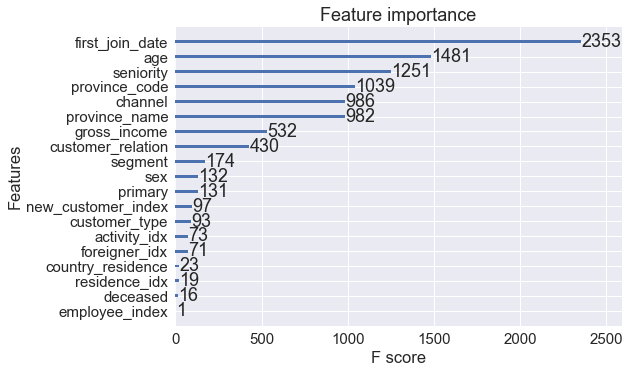

In [54]:
    param = def_param()
    fit_pred(X_train, y_train, X_test, y_test,param)

Turning the parameter 'min_child_weight'.

min_child_weight: 3

Model Report
Accuracy (Train) : 0.7611
AUC Score (Train): 0.822553


Analyzing Performance on Test Data
Accuracy (Test) : 0.7609
AUC Score (Test): 0.820463
min_child_weight: 5

Model Report
Accuracy (Train) : 0.7609
AUC Score (Train): 0.822502


Analyzing Performance on Test Data
Accuracy (Test) : 0.7608
AUC Score (Test): 0.820457


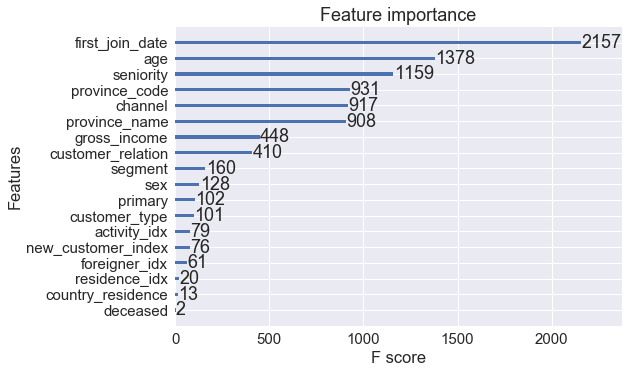

In [56]:
for i in [3,5]:

    param['min_child_weight'] = i
    print "min_child_weight: %i" % i
    fit_pred(X_train, y_train, X_test, y_test,param)

{'customer_type',
 'deceased',
 'gross_income',
 'new_customer_index',
 'primary',
### 'seniority'}

## Feature importance

The plot tells us which features were most important in the series of trees.The ‘first_join_data’ feature 
seems to have the most importance. Seniority and age was also important. Employee index and deceased info were not as important. 


max_depth: 8

Model Report
Accuracy (Train) : 0.7612
AUC Score (Train): 0.822797


Analyzing Performance on Test Data
Accuracy (Test) : 0.7608
AUC Score (Test): 0.820525
[[ 77265  44599]
 [ 28935 156581]]



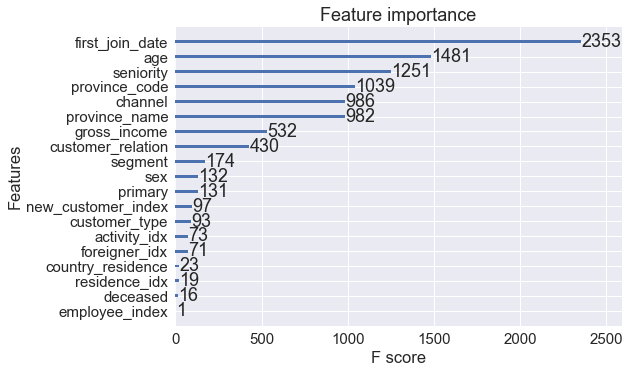

In [76]:
param = def_param()
for i in [8]:

    param['max_depth'] = i
    print "max_depth: %i" % i
    #model,predictions_train,predictions_test = fit_pred(X_train, y_train, X_test, y_test,param)
    fit_pred(X_train, y_train, X_test, y_test,param)
    print "========================================\n"
    #print confusion_matrix(y_test, predictions_test)

Explaination of Confusion matrix

>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
       
       
                 Pred
             ant bird cat
       ant
Acture bird
       cat

In [77]:
print param

{'colsample_bytree': 0.7, 'silent': 1, 'eval_metric': 'auc', 'min_child_weight': 1, 'subsample': 0.7, 'eta': 0.05, 'objective': 'binary:logistic', 'seed': 0, 'max_depth': 8}


## Summary


In [26]:
from sklearn.linear_model import LogisticRegression
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X_train, y_train)
# check the accuracy on the training set
model.score(X_train, y_train)

0.60315860484270267